In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from medmnist import INFO, PneumoniaMNIST
from transformers import ViTForImageClassification
from transformers import AdamW

def load_data(data_flag='pneumoniamnist', batch_size=16):
    n_classes = len(INFO[data_flag]['label'])
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Lambda(lambda x: x.repeat(3, 1, 1)),
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, n_classes

def setup_model(n_classes):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes)
    return model

def train_and_evaluate(model, train_loader, val_loader, device):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0
    best_model_path = 'best_model.pth'

    model.train()
    for epoch in range(10):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1).long()

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1).long()

                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Accuracy: {accuracy}%')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with accuracy: {accuracy}% at epoch {epoch+1}")

    print(f'Training complete. Best model was saved with an accuracy of {best_accuracy}%.')




def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, val_loader, test_loader, n_classes = load_data()
    model = setup_model(n_classes)
    train_and_evaluate(model, train_loader, val_loader, device)

if __name__ == '__main__':
    main()

Using downloaded and verified file: C:\Users\metho\.medmnist\pneumoniamnist.npz


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 87.82051282051282%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

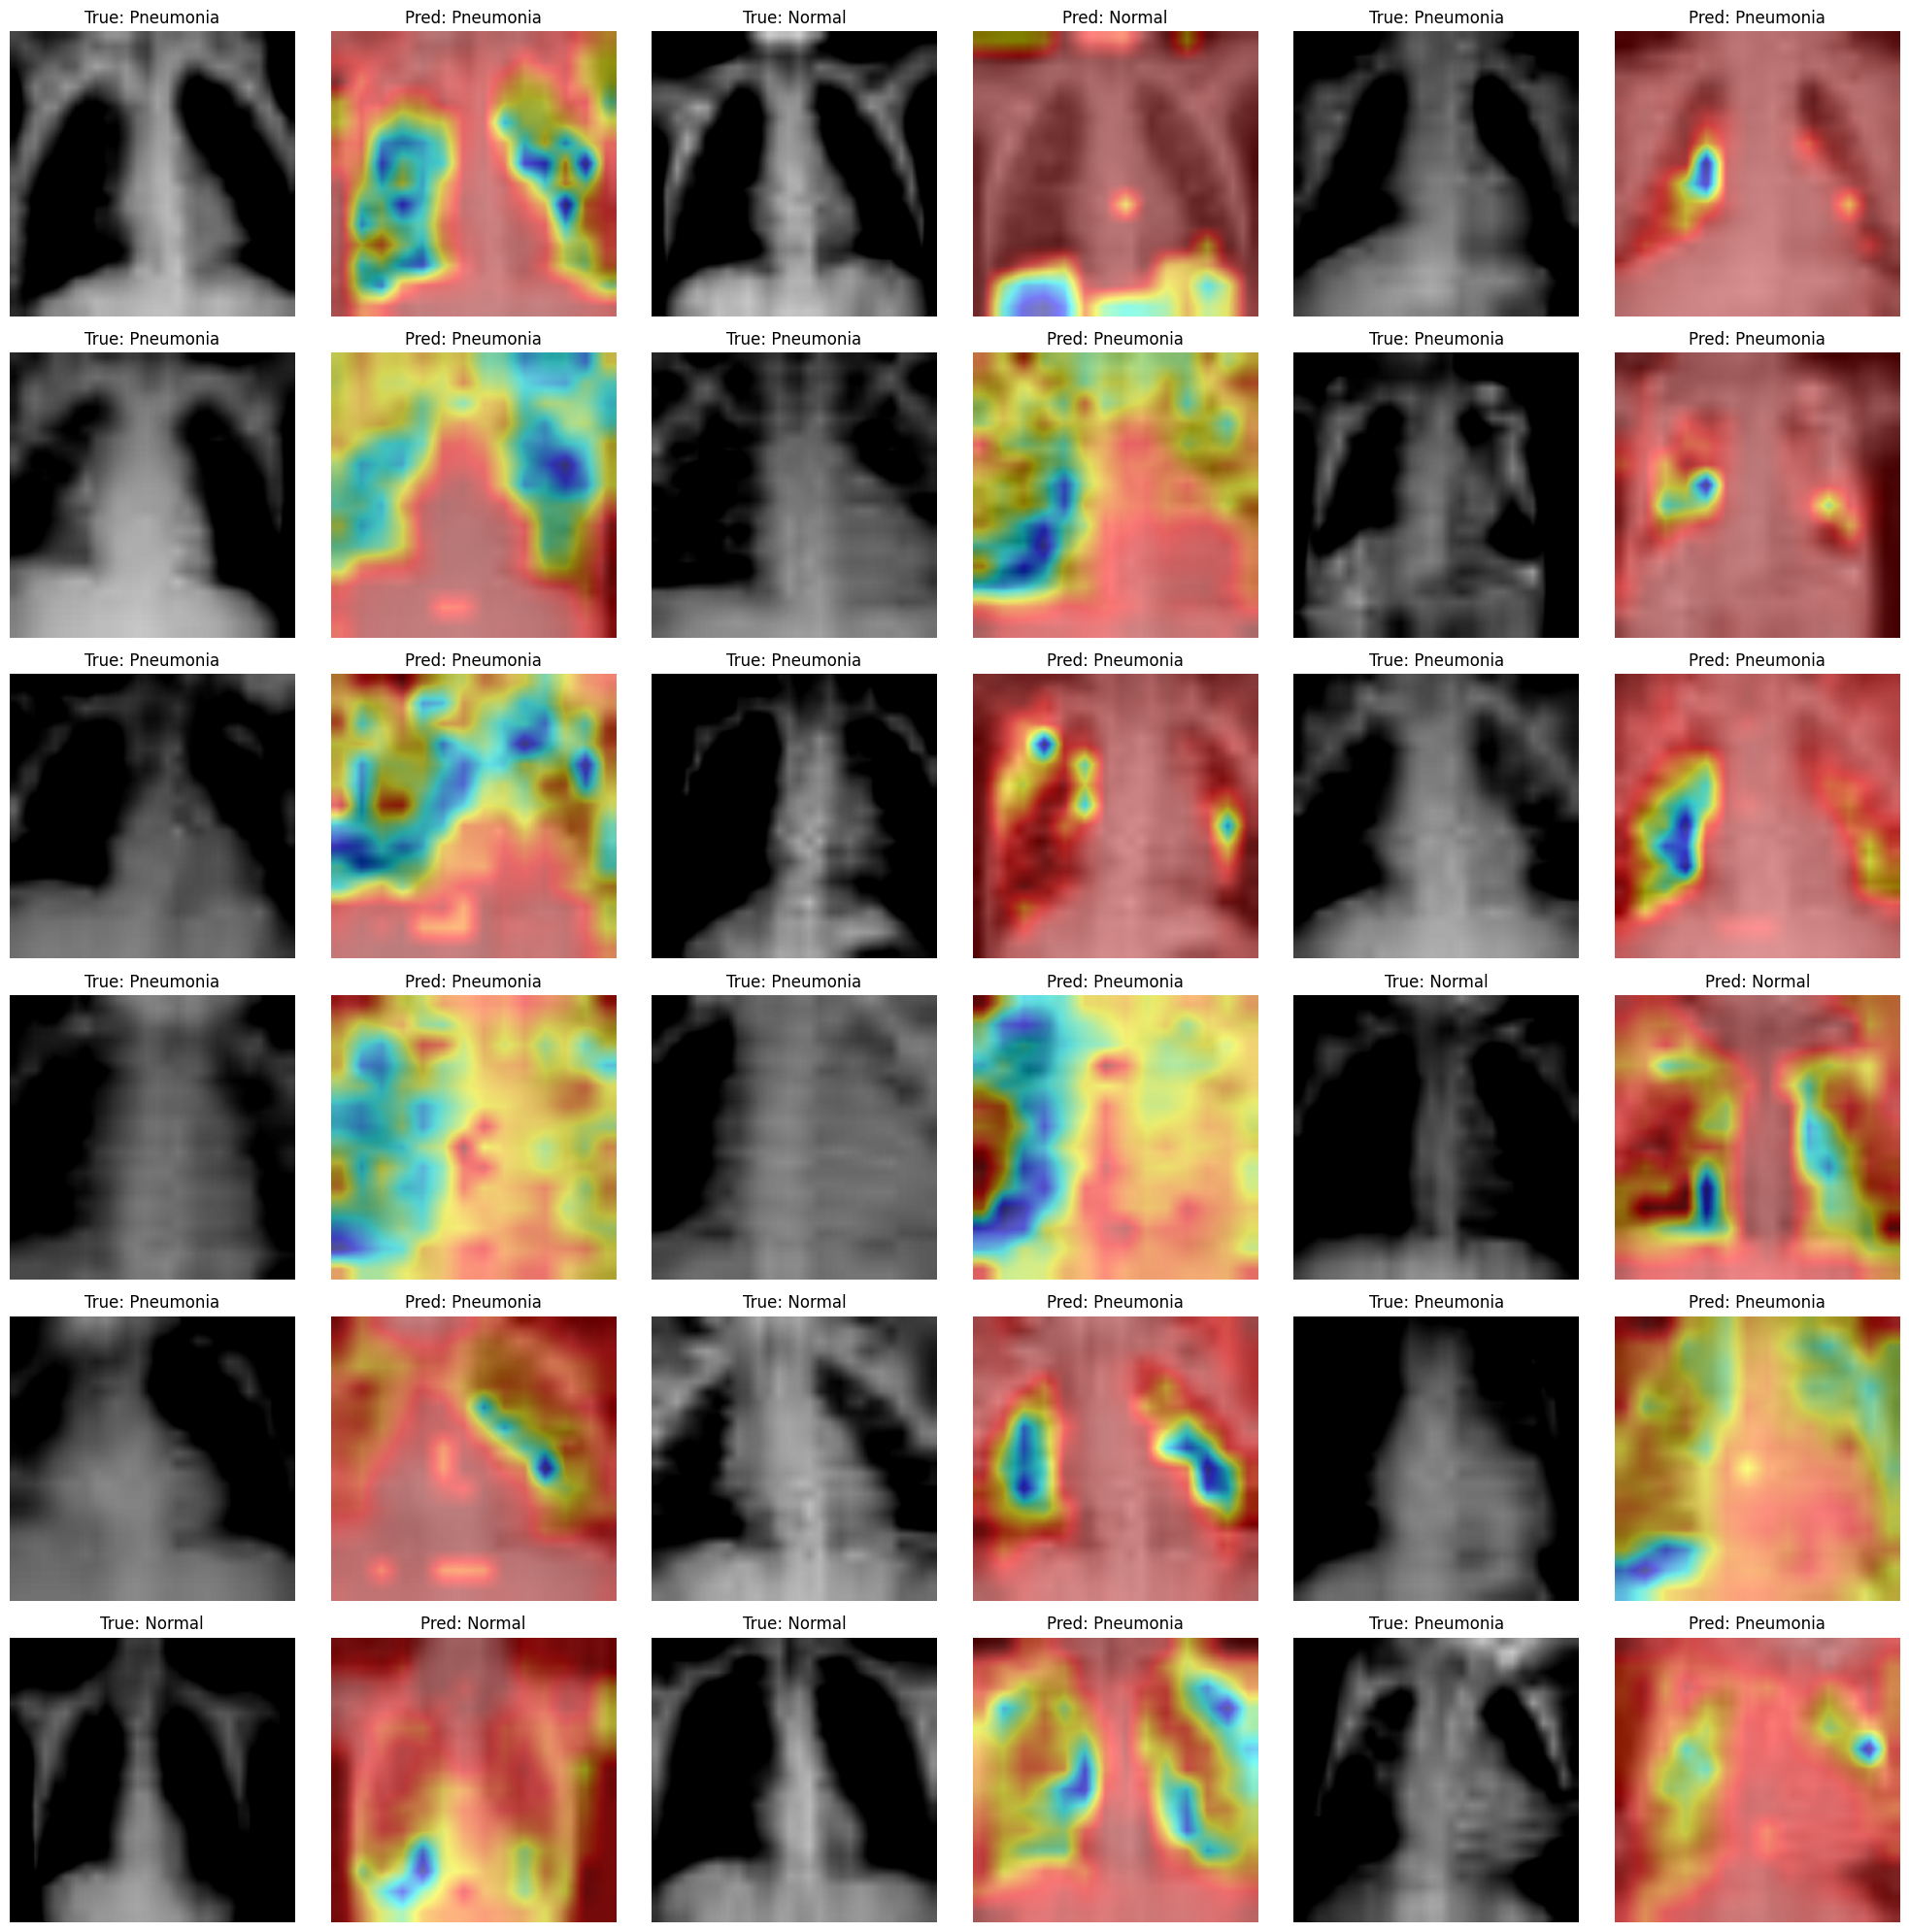

Confusion Matrix:
 [[158  76]
 [  0 390]]
Shape of Confusion Matrix: (2, 2)


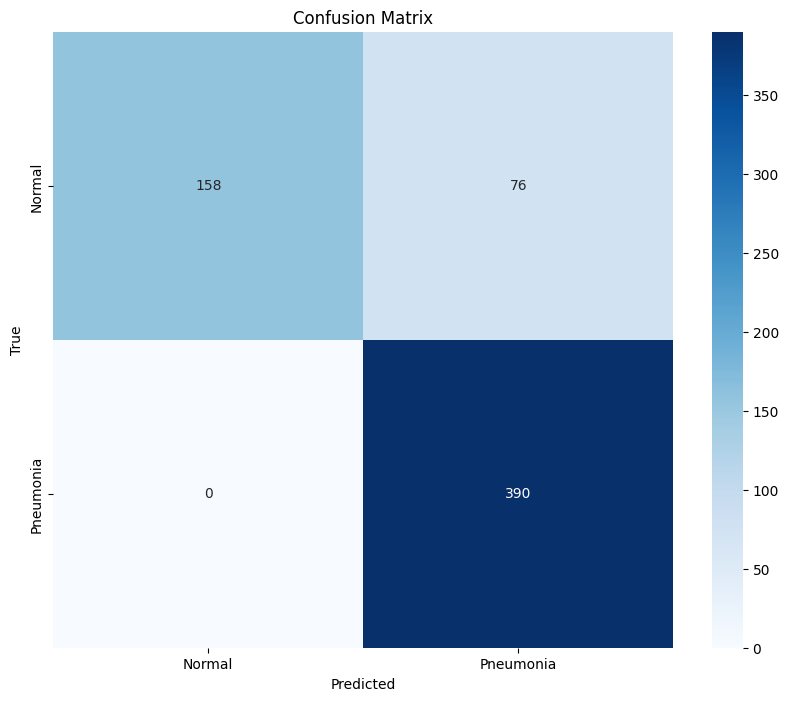


Classification Report:

              precision    recall  f1-score   support

      Normal     1.0000    0.6752    0.8061       234
   Pneumonia     0.8369    1.0000    0.9112       390

    accuracy                         0.8782       624
   macro avg     0.9185    0.8376    0.8587       624
weighted avg     0.8981    0.8782    0.8718       624



In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from medmnist import PneumoniaMNIST
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import random

CLASS_NAMES = ["Normal", "Pneumonia"]

def load_test_data(batch_size=16):
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the grayscale image to 3 channels
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

def load_model(n_classes, model_path='best_model.pth'):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes, output_attentions=True)
    model.load_state_dict(torch.load(model_path))
    return model

def visualize_attention(image, attentions, label, pred, layer_idx=11, head_idx=0):
    # Get the attention map of the specified layer and head
    attention = attentions[layer_idx][0, head_idx]  # Shape: (num_patches, num_patches)

    # Exclude the classification token
    attention = attention[1:, 1:]

    # Average the attention weights across all heads if needed
    attention = attention.mean(dim=0)

    # Reshape the attention map to match the image size
    grid_size = int(np.sqrt(attention.shape[0]))
    attention = attention.view(grid_size, grid_size).detach().cpu().numpy()

    # Resize to the original image size
    attention = cv2.resize(attention, (image.shape[2], image.shape[1]))

    # Normalize the attention map for visualization
    attention = (attention - attention.min()) / (attention.max() - attention.min())

    # Convert to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * attention), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Convert the original image to numpy
    image = image.permute(1, 2, 0).cpu().numpy()

    # Normalize the original image
    image = (image - image.min()) / (image.max() - image.min())

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap + image
    superimposed_img = superimposed_img / np.max(superimposed_img)

    return superimposed_img, label, pred

def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()

    total, correct = 0, 0
    all_labels, all_preds = [], []
    selected_images = []

    # Generate random indices
    random_indices = random.sample(range(len(test_loader.dataset)), 18)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1).long()  # Ensure labels are in the correct format

            outputs = model(images)
            attentions = outputs.attentions
            logits = outputs.logits

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Select random images
            for idx in range(images.size(0)):
                if len(selected_images) < 18 and (batch_idx * test_loader.batch_size + idx) in random_indices:
                    selected_images.append((images[idx], [att[idx].unsqueeze(0) for att in attentions], labels[idx].item(), predicted[idx].item()))

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')

    # Combine selected images for visualization
    plot_selected_images(selected_images)

    return all_labels, all_preds

def plot_selected_images(selected_images):
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    axes = axes.flatten()
    for i, (image, attentions, label, pred) in enumerate(selected_images):
        img_with_attention, true_label, pred_label = visualize_attention(image, attentions, CLASS_NAMES[label], CLASS_NAMES[pred])
        
        # 原始图像
        axes[2*i].imshow(image.permute(1, 2, 0).cpu().numpy())
        axes[2*i].set_title(f'True: {CLASS_NAMES[label]}')
        axes[2*i].axis('off')

        # 注意力图像
        axes[2*i+1].imshow(img_with_attention)
        axes[2*i+1].set_title(f'Pred: {CLASS_NAMES[pred]}')
        axes[2*i+1].axis('off')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(labels, preds, n_classes):
    cm = confusion_matrix(labels, preds, labels=range(n_classes))
    print("Confusion Matrix:\n", cm)  # Add this line for debugging
    print("Shape of Confusion Matrix:", cm.shape)  # Add this line for debugging
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(labels, preds):
    report = classification_report(labels, preds, target_names=CLASS_NAMES, digits=4)
    print("\nClassification Report:\n")
    print(report)

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_loader = load_test_data()
    n_classes = len(CLASS_NAMES)  # Update this if the number of classes changes
    model = load_model(n_classes)
    labels, preds = evaluate(model, test_loader, device)
    plot_confusion_matrix(labels, preds, n_classes)
    print_classification_report(labels, preds)

if __name__ == '__main__':
    main()


In [1]:
import torch
torch.cuda.empty_cache()